In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import os
from pathlib import Path
import torch
import xgboost as xgb
import torch.nn as nn
import joblib

In [2]:
class DiamondPriceMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3, use_batch_norm=True, target_mean=None):
        super(DiamondPriceMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
        
        self._initialize_weights(target_mean)
    
    def _initialize_weights(self, target_mean):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if target_mean is not None:
            nn.init.constant_(self.network[-1].bias, target_mean)
    
    def forward(self, x):
        return self.network(x).squeeze()

In [3]:
# Helper function to calculate and print metrics
def print_metrics(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n--- {model_name} Performance ---")
    print(f"RMSE:     ${rmse:,.2f}")
    print(f"R² Score:  {r2:.4f}")
    print(f"MAPE:      {mape * 100:.2f}%")
    return {"rmse": rmse, "r2": r2, "mape": mape}

In [4]:
script_dir = os.getcwd()
data_dir = Path(script_dir).parent / "data"
models_dir = Path(script_dir).parent / "models"

In [5]:
# Load the preprocessed data
X_train = np.load(f'{data_dir}/X_train_final.npy')
X_val = np.load(f'{data_dir}/X_val_final.npy')
X_test = np.load(f'{data_dir}/X_test_final.npy')

y_train_log = np.load(f'{data_dir}/y_train_log.npy')  # Log-transformed version!
y_val_log = np.load(f'{data_dir}/y_val_log.npy')
y_test_log = np.load(f'{data_dir}/y_test_log.npy')

In [6]:
X_train.shape

(151143, 52)

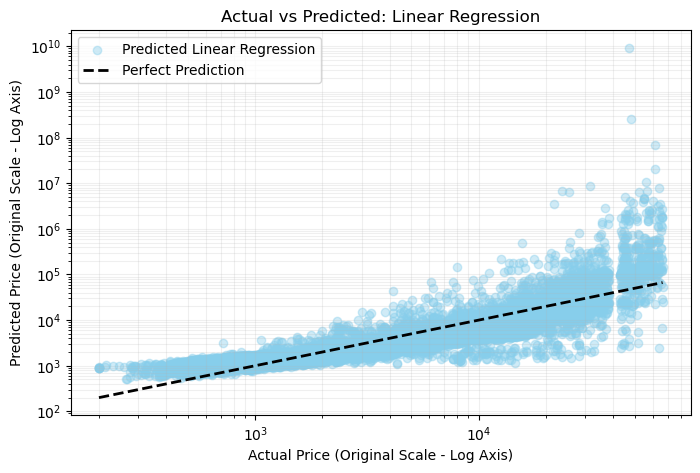

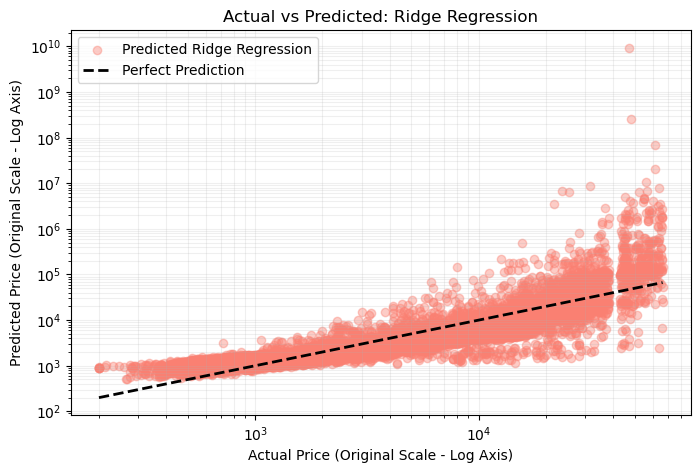

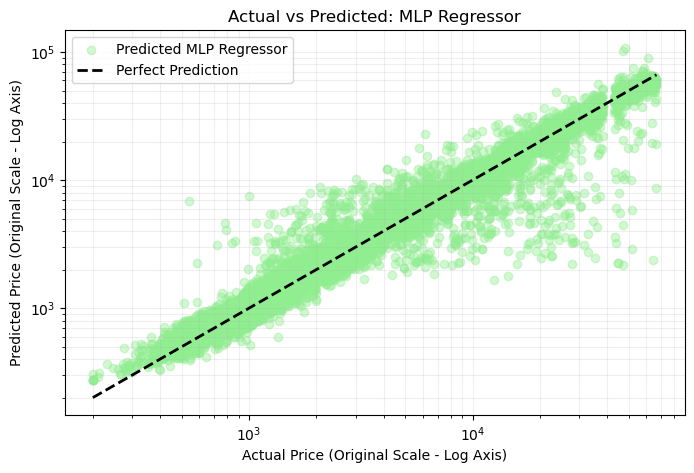

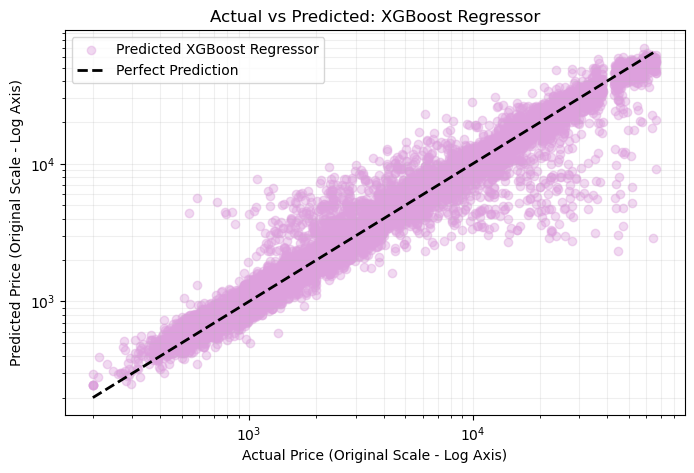


             FINAL MODEL COMPARISON (TEST SET)              
Model Name             | RMSE         | R2         | MAPE    
------------------------------------------------------------
Linear Regression      | $52119176.61 | -39247984.7656 |  689.10%
Ridge Regression       | $52124589.60 | -39256137.6151 |  689.13%
MLP Regressor          | $   2182.57 |     0.9312 |   10.00%
XGBoost Regressor      | $   2181.75 |     0.9312 |   10.41%


In [15]:
# A. Load MLP
checkpoint = torch.load(f'{models_dir}/best_diamond_mlp_model.pth', weights_only=False)
loaded_mlp = DiamondPriceMLP(**checkpoint['hyperparameters'])
loaded_mlp.load_state_dict(checkpoint['model_state_dict'])
loaded_mlp.eval()

# B. Load XGBoost
loaded_xgb = xgb.XGBRegressor()
loaded_xgb.load_model(os.path.join(models_dir, 'diamond_xgb_model.json'))

# C. Linear & Ridge (Assuming these were loaded/defined as 'model_linear' and 'model_ridge')
# Load the Linear Regression model
model_linear = joblib.load(os.path.join(models_dir, 'linear_regression_model.joblib'))

# Load the Ridge Regression model
model_ridge = joblib.load(os.path.join(models_dir, 'ridge_regression_model.joblib'))

# 2. GENERATE PREDICTIONS
# ------------------------------------------------------------------
y_test_actual = np.expm1(y_test_log)

# Linear Regression
y_test_pred_linear = np.expm1(model_linear.predict(X_test))

# Ridge Regression
y_test_pred_ridge = np.expm1(model_ridge.predict(X_test))

# MLP (PyTorch)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_test_pred_mlp = np.expm1(loaded_mlp(X_test_tensor).numpy().flatten())

# XGBoost
y_test_pred_xgb = np.expm1(loaded_xgb.predict(X_test))

# 3. PLOT GRAPHS FIRST
# ------------------------------------------------------------------
models_data = [
    ("Linear Regression", y_test_pred_linear, 'skyblue'),
    ("Ridge Regression", y_test_pred_ridge, 'salmon'),
    ("MLP Regressor", y_test_pred_mlp, 'lightgreen'),
    ("XGBoost Regressor", y_test_pred_xgb, 'plum')
]

for name, y_pred, color in models_data:
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test_actual, y_pred, alpha=0.4, color=color, label=f'Predicted {name}')
    
    # Perfect Prediction Line
    line_min, line_max = y_test_actual.min(), y_test_actual.max()
    plt.plot([line_min, line_max], [line_min, line_max], 'k--', lw=2, label='Perfect Prediction')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Actual Price (Original Scale - Log Axis)')
    plt.ylabel('Predicted Price (Original Scale - Log Axis)')
    plt.title(f'Actual vs Predicted: {name}')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

# 4. PRINT SUMMARY TABLE LAST
# ------------------------------------------------------------------
print("\n" + "="*60)
print(f"{'FINAL MODEL COMPARISON (TEST SET)':^60}")
print("="*60)
print(f"{'Model Name':<22} | {'RMSE':<12} | {'R2':<10} | {'MAPE':<8}")
print("-" * 60)

results_summary = []
for name, y_pred, _ in models_data:
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    r2 = r2_score(y_test_actual, y_pred)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred)
    
    print(f"{name:<22} | ${rmse:>10.2f} | {r2:>10.4f} | {mape*100:>7.2f}%")

print("="*60)